<a href="https://colab.research.google.com/github/medbar/maga_sis/blob/main/2/ED/Mitrofanov_Lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import librosa
from librosa.feature import melspectrogram
from librosa.core import load
from librosa.display import specshow
from librosa import power_to_db

import matplotlib.pyplot as plt

# from utils.preprocessing import extract_log_mel_feats
# run git log чтобы посмотреть предыдущие версии кода, где не было исправлений

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
from tqdm import tqdm
import pickle
import pandas as pd
import numpy as np

from librosa.feature import melspectrogram
from librosa.core import load as load_wav
from librosa import power_to_db


def extract_log_mel_feats(set_type, path_to_csv, path_to_files, out_path, sr, fft_size, hop, n_mels):
    """
    Extract features from given files and store them in binary format.

    :param set_type:
    :param path_to_csv: path to loaded csv
    :param path_to_files: path to loaded data
    :param out_path: path to store extracted features
    :param sr: input files sample rate
    :param fft_size: size of fft window
    :param hop: hop size
    :param n_mels: number of mel band

    :return:

    """
    set_type = set_type.lower()
    if set_type not in ['train', 'test']:
        raise Exception('Such set type not supported: {}'.format(set_type))

    feats = []

    if set_type == 'train':
        meta = pd.read_csv(path_to_csv, skiprows=1, names=['fname', 'label', 'manually_verified'])

        file_names = list(meta['fname'])
        n_files = len(file_names)
        labels = list(meta['label'])

        uniq_labels = np.sort(np.unique(labels))
        label_to_id = {label: i for i, label in enumerate(uniq_labels)}

        print('Total files:', n_files)
        if os.path.exists(out_path):
          print(f"Feats {out_path} already exists!")
          return label_to_id

        for i, (file_name, label) in tqdm(enumerate(zip(file_names, labels))):
            wav_data, sr = load_wav(os.path.join(path_to_files, file_name), sr=sr)
            mel_spec = melspectrogram(wav_data, n_fft=fft_size, hop_length=hop, n_mels=n_mels, fmax=sr // 2)
            log_mel_spec = power_to_db(mel_spec, ref=np.max)
            feats.append({
                'fname': file_name,
                'feature': log_mel_spec,
                'label_id': label_to_id[label]
            })
        pickle.dump(feats, open(out_path, 'wb'))    
        return label_to_id
    else:
        for i, file_name in tqdm(enumerate(os.listdir(path_to_files))):
            wav_data, sr = load_wav(os.path.join(path_to_files, file_name), sr=sr)
            if len(wav_data) == 0:
                # print('Empty file:', file_name)
                wav_data = np.zeros(sr)
            mel_spec = melspectrogram(wav_data, n_fft=fft_size, n_mels=n_mels, fmax=sr // 2)
            log_mel_spec = power_to_db(mel_spec, ref=np.max)
            feats.append({
                'fname': file_name,
                'feature': log_mel_spec,
            })

    pickle.dump(feats, open(out_path, 'wb'))

In [ ]:
#!mkdir data && cp /content/gdrive/MyDrive/учебка/магистратура/2/ED/audio_train.zip data/ && unzip data/audio_train.zip 

In [ ]:
train_folder = 'train'
# test_folder = './data/audio_test/'

sample_rate = 11025
fft_size = 1024
overlap = 4
hop = fft_size // overlap
mels = 64

In [ ]:
# wav_data, sr = load(os.path.join(train_folder, '8bcbcc394ba64fe85ed4.wav'), sr=sample_rate)
# mel_spec = melspectrogram(wav_data, n_fft=fft_size, hop_length=hop, n_mels=mels, 
#                           fmax=sample_rate//2)

# plt.figure(figsize=(10, 4))
# colors = 'viridis'
# specshow(mel_spec, y_axis='mel', fmax=sample_rate//2, x_axis='time', cmap=colors)
# plt.colorbar(format='%+2.0f дБ')
# plt.title('Мелспектрограмма')
# plt.tight_layout()
# plt.show()

# plt.figure(figsize=(10, 4))
# specshow(power_to_db(mel_spec, ref=np.max), y_axis='mel',
#          fmax=sample_rate//2, x_axis='time', cmap=colors)
# plt.colorbar(format='%+2.0f дБ')
# plt.title('Логарифм мелспектрограммы')
# plt.tight_layout()
# plt.show()

In [ ]:
path_to_csv = os.path.join('/content/gdrive/MyDrive/учебка/магистратура/2/ED/train.csv')

pickle_train_path = os.path.join('/content/gdrive/MyDrive/учебка/магистратура/2/ED/', 'train.lab2.pickle')
# pickle_test_path = os.path.join('./data', 'test.pickle')

label_to_id = extract_log_mel_feats('train', path_to_csv, train_folder, pickle_train_path, sample_rate, fft_size, hop, mels)
id_to_label = [label for label, i in label_to_id.items()]

# extract_log_mel_feats('test', '', test_folder, pickle_test_path, sample_rate, fft_size, hop, mels)

Total files: 5683
Feats /content/gdrive/MyDrive/учебка/магистратура/2/ED/train.lab2.pickle already exists!


In [ ]:
#!mv data/train.pickle /content/gdrive/MyDrive/учебка/магистратура/2/ED/train.lab2.pickle

In [ ]:
import numpy as np
import pandas as pd
import soundfile as sf
import torch.nn.functional as F
import torch.nn as nn
import torch


class DummyNetwork(nn.Module):
    def __init__(self): #, input_feats_h=64, input_feats_w=128
        super(DummyNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=(1, 1))
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=(1, 1))
        #self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=(1, 1))
        
        self.mp = nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1))
        
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.3)
        self.dropout3 = nn.Dropout(p=0.3)
        #self.dropout4 = nn.Dropout(p=0.3)
        
        self.bn1 = nn.BatchNorm2d(num_features=32)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        #self.bn4 = nn.BatchNorm2d(num_features=128)
        
        # вставим mean пулинг
        self.flat = nn.Flatten()
        # 2560 - должно соответствовать форме self.flat
        self.fc1 = nn.Linear(1472*2, 41)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.mp(x)
        x = self.dropout3(x)

        # x = self.conv4(x)
        # x = self.bn4(x)
        # x = F.relu(x)
        # x = self.mp(x)
        # x = self.dropout4(x)
        
        #print(x.shape)
        x = torch.cat((x.mean(dim=-1), x.std(dim=-1)), dim=-1)
        x = self.flat(x)
        # здесь можно еще добавить полносвязных слой или слои
        x = self.fc1(x)
        return x


In [ ]:
random_input = torch.randn(1, 1, 64, 64*2, requires_grad=True)
network = DummyNetwork()
output = network(random_input)
print(output)

tensor([[-0.1271,  0.3071, -0.5734, -0.0884, -0.6678, -0.7478, -0.3248,  0.3548,
         -1.0658,  0.4501,  0.3579, -0.1070, -0.1601, -0.2252, -1.0192,  0.1722,
          0.5196, -0.8514, -0.0496, -0.8985,  0.3742, -0.8955, -0.4258,  0.0395,
         -0.8917,  0.0715,  0.0249, -0.2475,  0.1218,  0.2623,  0.3130, -0.1836,
         -1.6393, -0.5966,  0.0140, -0.5831,  0.4280, -0.6245, -0.5729, -0.7979,
          0.3523]], grad_fn=<AddmmBackward>)


In [ ]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(network.parameters(), lr=0.001)
optimizer.zero_grad()

random_input = torch.randn(3, 1, 64, 64, requires_grad=True)

output = network(random_input)
target = torch.empty(3, dtype=torch.long).random_(5)

loss = criterion(output, target)

print(loss.item())

loss.backward()
optimizer.step() 

3.7720115184783936


In [ ]:
import pickle

pickle_train_data = pickle.load(open(pickle_train_path, 'rb'))

In [ ]:
# можно улучшить, используя сбалансированное валидационное множество
# гуглить stratified train test split sklearn
validation_set_size = 800

x_val = []
y_val = []

x_tr = []
y_tr = []

for i, row in enumerate(pickle_train_data):
    feature = row['feature']
    if i < validation_set_size:
        x_val.append(feature)
        y_val.append(row['label_id'])
    else:
        x_tr.append(feature)
        y_tr.append(row['label_id'])
#x_val = np.asarray(x_val)
#x_tr = np.asarray(x_tr)

y_val = np.asarray(y_val)
y_tr = np.asarray(y_tr)

In [ ]:
from torch.utils.data import Dataset
import random 
random.seed(42)

def prepare_shape(feature, shift=0):
    tmp = feature
    N = 64*2 # размер во времени (можно увеличить, должно стать лучше)
    while tmp.shape[1] < N:
        # можно попробовать сделать np.pad для коротких файлов, вместо повторения до необходимой длины
        tmp = np.hstack((tmp, tmp))
    # случайный сдвиг должен улучшить результат (для этого нужно функцию перенести в EventDetectionDataset)
    tmp = tmp[np.newaxis, :, shift:shift+N]
    return tmp

class EventDetectionDataset(Dataset):
    def __init__(self, x, y=None):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        # добавить сюда prepare_shape()
        feats = self.x[idx]
        if len(feats) > 64:
          shift = random.randint(0, len(feats)-64)
        else:
          shift=0
        x_window = prepare_shape(feats, shift=shift)
        if self.y is not None:
            return x_window, self.y[idx]
        return x_window

In [ ]:
from torch.utils.data import DataLoader

train_dset = EventDetectionDataset(x_tr, y_tr)
val_dset = EventDetectionDataset(x_val, y_val)
train_loader = DataLoader(train_dset, batch_size=41, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dset, batch_size=41, shuffle=False, num_workers=0)

14


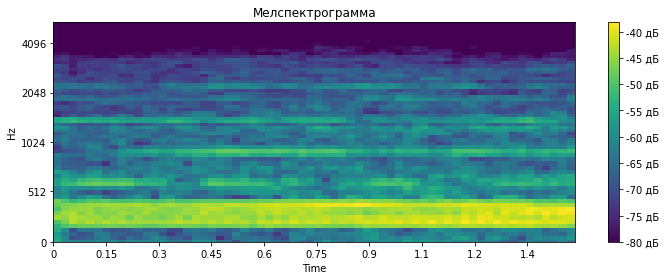

In [ ]:
sample_x, sample_y = val_dset[2]
print(sample_y)
# print(id_to_label[sample_y])
plt.figure(figsize=(10, 4))
colors = 'viridis'
specshow(sample_x[0], y_axis='mel', fmax=sample_rate//2, x_axis='time', cmap=colors)
plt.colorbar(format='%+2.0f дБ')
plt.title('Мелспектрограмма')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
n_epoch = 50
criterion = nn.CrossEntropyLoss()
network = DummyNetwork()
# можно попробовать другой optimizer, тоже считается улучшением
optimizer = optim.Adam(network.parameters(), lr=0.001)

train_loss = []
val_loss = []

train_acc = []
val_acc = []

for e in range(n_epoch):
    print('epoch #', e)
    # train
    loss_list = []
    outputs = []
    targets = []
    for i_batch, sample_batched in enumerate(train_loader):
        x, y = sample_batched
        optimizer.zero_grad()

        output = network(x)
        outputs.append(output.detach().numpy().argmax(axis=1))
    
        target = y
        targets.append(target)
        
        loss = criterion(output, target.long())
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
    y_true = np.hstack(targets)
    y_pred = np.hstack(outputs)
    acc = accuracy_score(y_true, y_pred)
    train_loss.append(np.mean(loss_list))
    train_acc.append(acc)
    print('mean train loss:', train_loss[-1])
    print('train accuracy:', acc)
    
    
    loss_list = []
    outputs = []
    targets = []
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(val_loader):
            x, y = sample_batched
#             optimizer.zero_grad()

            output = network(x)
            outputs.append(output.detach().numpy().argmax(axis=1))

            target = y
            targets.append(target)

            loss = criterion(output, target.long())
            loss_list.append(loss.item())
#             loss.backward()
#             optimizer.step()
            
        y_true = np.hstack(targets)
        y_pred = np.hstack(outputs)
        acc = accuracy_score(y_true, y_pred)
        val_loss.append(np.mean(loss_list))
        val_acc.append(acc)
        print('mean val loss:', val_loss[-1])
        print('val accuracy:', acc)

epoch # 0
mean train loss: 2.9977061371008555
train accuracy: 0.17857874257628506
mean val loss: 2.738593649864197
val accuracy: 0.22125
epoch # 1
mean train loss: 2.4561594098806383
train accuracy: 0.3266434568912554
mean val loss: 2.3942037224769592
val accuracy: 0.32625
epoch # 2
mean train loss: 2.1879490087429683
train accuracy: 0.39975424943682164
mean val loss: 2.0851763010025026
val accuracy: 0.41
epoch # 3
mean train loss: 2.0251556158065798
train accuracy: 0.43702641818554167
mean val loss: 1.92114360332489
val accuracy: 0.46375
epoch # 4
mean train loss: 1.878857640425364
train accuracy: 0.4872004915011264
mean val loss: 2.012153607606888
val accuracy: 0.425
epoch # 5
mean train loss: 1.8047089154521625
train accuracy: 0.500921564611919
mean val loss: 1.9315993010997772
val accuracy: 0.46625
epoch # 6
mean train loss: 1.7077112009127935
train accuracy: 0.5263157894736842
mean val loss: 1.7389285624027253
val accuracy: 0.51625
epoch # 7
mean train loss: 1.6404095004002253
tra

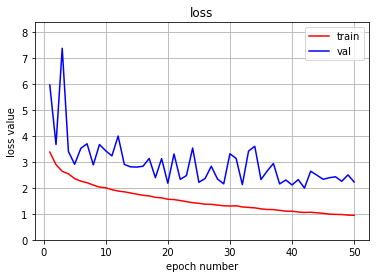

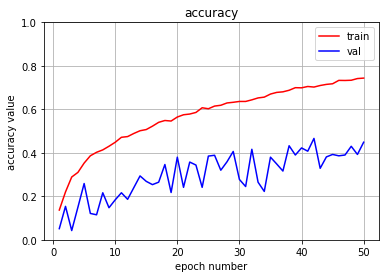

In [ ]:
epochs = np.arange(1, n_epoch+1)

axes = plt.gca()
axes.set_ylim([0,max(max(train_loss), max(val_loss))+1])
plt.plot(epochs, train_loss, 'r', label='train')
plt.plot(epochs, val_loss, 'b', label='val')
plt.title('loss')
plt.xlabel('epoch number')
plt.ylabel('loss value')
plt.legend()
plt.grid()
plt.show()


axes = plt.gca()
axes.set_ylim([0,1])
plt.plot(epochs, train_acc, 'r', label='train')
plt.plot(epochs, val_acc, 'b', label='val')
plt.title('accuracy')
plt.xlabel('epoch number')
plt.ylabel('accuracy value')
plt.legend()
plt.grid()
plt.show()

In [ ]:
#baseline. val accuracy 0.44875
#kmeans. val accuracy 0.51
#adam 1e-3 average pooling. val accuracy 0.605


In [ ]:
n_epoch = 50
criterion = nn.CrossEntropyLoss()
network = DummyNetwork().cuda()
# можно попробовать другой optimizer, тоже считается улучшением
optimizer = optim.Adam(network.parameters(), lr=0.001)

train_loss = []
val_loss = []

train_acc = []
val_acc = []

for e in range(n_epoch):
    print('epoch #', e)
    # train
    loss_list = []
    outputs = []
    targets = []
    for i_batch, sample_batched in enumerate(train_loader):
        x, y = sample_batched
        optimizer.zero_grad()

        output = network(x.cuda())
        outputs.append(output.detach().cpu().numpy().argmax(axis=1))
    
        target = y.cuda()
        targets.append(y)
        
        loss = criterion(output, target.long())
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
    y_true = np.hstack(targets)
    y_pred = np.hstack(outputs)
    acc = accuracy_score(y_true, y_pred)
    train_loss.append(np.mean(loss_list))
    train_acc.append(acc)
    print('mean train loss:', train_loss[-1])
    print('train accuracy:', acc)
    
    
    loss_list = []
    outputs = []
    targets = []
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(val_loader):
            x, y = sample_batched
#             optimizer.zero_grad()

            output = network(x.cuda())
            outputs.append(output.detach().cpu().numpy().argmax(axis=1))

            target = y.cuda()
            targets.append(y)

            loss = criterion(output, target.long())
            loss_list.append(loss.item())
#             loss.backward()
#             optimizer.step()
            
        y_true = np.hstack(targets)
        y_pred = np.hstack(outputs)
        acc = accuracy_score(y_true, y_pred)
        val_loss.append(np.mean(loss_list))
        val_acc.append(acc)
        print('mean val loss:', val_loss[-1])
        print('val accuracy:', acc)

epoch # 0
mean train loss: 2.956881906588872
train accuracy: 0.2056113045259062
mean val loss: 2.521427130699158
val accuracy: 0.2725
epoch # 1
mean train loss: 2.439937820037206
train accuracy: 0.32009010853983205
mean val loss: 2.2245158433914183
val accuracy: 0.385
epoch # 2
mean train loss: 2.131676145394643
train accuracy: 0.40999385623592055
mean val loss: 2.1323950588703156
val accuracy: 0.4075
epoch # 3
mean train loss: 1.9643624514341353
train accuracy: 0.4564816711038296
mean val loss: 1.9474591732025146
val accuracy: 0.47625
epoch # 4
mean train loss: 1.8158028870821
train accuracy: 0.5087036657792341
mean val loss: 1.8441455900669097
val accuracy: 0.49625
epoch # 5
mean train loss: 1.7253067662318549
train accuracy: 0.5203768175302068
mean val loss: 1.764995175600052
val accuracy: 0.5325
epoch # 6
mean train loss: 1.6097028116385141
train accuracy: 0.5531435592873234
mean val loss: 1.6786617130041122
val accuracy: 0.5375
epoch # 7
mean train loss: 1.5272474487622578
train a

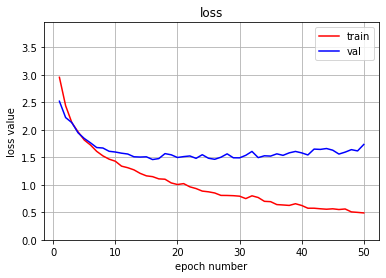

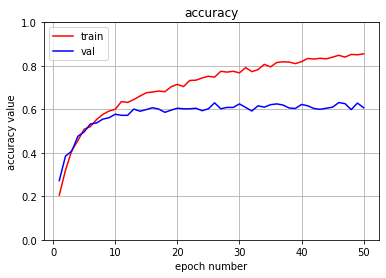

In [ ]:
epochs = np.arange(1, n_epoch+1)

axes = plt.gca()
axes.set_ylim([0,max(max(train_loss), max(val_loss))+1])
plt.plot(epochs, train_loss, 'r', label='train')
plt.plot(epochs, val_loss, 'b', label='val')
plt.title('loss')
plt.xlabel('epoch number')
plt.ylabel('loss value')
plt.legend()
plt.grid()
plt.show()


axes = plt.gca()
axes.set_ylim([0,1])
plt.plot(epochs, train_acc, 'r', label='train')
plt.plot(epochs, val_acc, 'b', label='val')
plt.title('accuracy')
plt.xlabel('epoch number')
plt.ylabel('accuracy value')
plt.legend()
plt.grid()
plt.show()

In [ ]:
#baseline. val accuracy 0.44875
#kmeans. val accuracy 0.51
#adam 1e-3 average pooling, X2 input len. val accuracy 0.63


In [ ]:
n_epoch = 50
criterion = nn.CrossEntropyLoss()
network = DummyNetwork().cuda()
# можно попробовать другой optimizer, тоже считается улучшением
optimizer = optim.Adam(network.parameters(), lr=0.001)

train_loss = []
val_loss = []

train_acc = []
val_acc = []

for e in range(n_epoch):
    print('epoch #', e)
    # train
    loss_list = []
    outputs = []
    targets = []
    for i_batch, sample_batched in enumerate(train_loader):
        x, y = sample_batched
        optimizer.zero_grad()

        output = network(x.cuda())
        outputs.append(output.detach().cpu().numpy().argmax(axis=1))
    
        target = y.cuda()
        targets.append(y)
        
        loss = criterion(output, target.long())
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
    y_true = np.hstack(targets)
    y_pred = np.hstack(outputs)
    acc = accuracy_score(y_true, y_pred)
    train_loss.append(np.mean(loss_list))
    train_acc.append(acc)
    print('mean train loss:', train_loss[-1])
    print('train accuracy:', acc)
    
    
    loss_list = []
    outputs = []
    targets = []
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(val_loader):
            x, y = sample_batched
#             optimizer.zero_grad()

            output = network(x.cuda())
            outputs.append(output.detach().cpu().numpy().argmax(axis=1))

            target = y.cuda()
            targets.append(y)

            loss = criterion(output, target.long())
            loss_list.append(loss.item())
#             loss.backward()
#             optimizer.step()
            
        y_true = np.hstack(targets)
        y_pred = np.hstack(outputs)
        acc = accuracy_score(y_true, y_pred)
        val_loss.append(np.mean(loss_list))
        val_acc.append(acc)
        print('mean val loss:', val_loss[-1])
        print('val accuracy:', acc)

epoch # 0
mean train loss: 3.011977767944336
train accuracy: 0.2189227933647348
mean val loss: 2.6221497774124147
val accuracy: 0.30625
epoch # 1
mean train loss: 2.4409462183713915
train accuracy: 0.32418595125947164
mean val loss: 2.259332424402237
val accuracy: 0.36
epoch # 2
mean train loss: 2.077327844997247
train accuracy: 0.4224861765308212
mean val loss: 1.9453106641769409
val accuracy: 0.44625
epoch # 3
mean train loss: 1.905104359984398
train accuracy: 0.4726602498464059
mean val loss: 1.9311507582664489
val accuracy: 0.44125
epoch # 4
mean train loss: 1.770993357896805
train accuracy: 0.4970305140282613
mean val loss: 1.7669835150241853
val accuracy: 0.4875
epoch # 5
mean train loss: 1.6610502461592356
train accuracy: 0.5308212164652877
mean val loss: 1.6861080944538116
val accuracy: 0.52875
epoch # 6
mean train loss: 1.5896427810192109
train accuracy: 0.5531435592873234
mean val loss: 1.7519521176815034
val accuracy: 0.495
epoch # 7
mean train loss: 1.5140301575263342
train

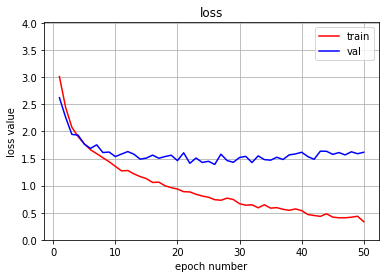

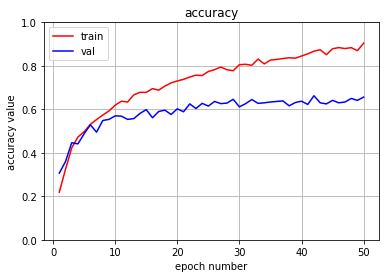

In [ ]:
epochs = np.arange(1, n_epoch+1)

axes = plt.gca()
axes.set_ylim([0,max(max(train_loss), max(val_loss))+1])
plt.plot(epochs, train_loss, 'r', label='train')
plt.plot(epochs, val_loss, 'b', label='val')
plt.title('loss')
plt.xlabel('epoch number')
plt.ylabel('loss value')
plt.legend()
plt.grid()
plt.show()


axes = plt.gca()
axes.set_ylim([0,1])
plt.plot(epochs, train_acc, 'r', label='train')
plt.plot(epochs, val_acc, 'b', label='val')
plt.title('accuracy')
plt.xlabel('epoch number')
plt.ylabel('accuracy value')
plt.legend()
plt.grid()
plt.show()

In [ ]:
#baseline. val accuracy 0.44875
#kmeans. val accuracy 0.51
#adam 1e-3 average pooling, X2 input len. val accuracy 0.63
#adam 1e-3 average pooling, X2 input len, AveragePooling with std. val accuracy 0.65

In [ ]:
# можно улучшить, используя сбалансированное валидационное множество
# гуглить stratified train test split sklearn
validation_set_size = 800

x_tr, x_val, y_tr, y_val = sklearn.model_selection.train_test_split()


for i, row in enumerate(pickle_train_data):
    feature = row['feature']
    if i < validation_set_size:
        x_val.append(feature)
        y_val.append(row['label_id'])
    else:
        x_tr.append(feature)
        y_tr.append(row['label_id'])
#x_val = np.asarray(x_val)
#x_tr = np.asarray(x_tr)

y_val = np.asarray(y_val)
y_tr = np.asarray(y_tr)

In [ ]:
train_dset = EventDetectionDataset(x_tr, y_tr)
val_dset = EventDetectionDataset(x_val, y_val)
train_loader = DataLoader(train_dset, batch_size=41, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dset, batch_size=41, shuffle=False, num_workers=0)